In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string

!pip install contractions

import contractions
import nltk
from nltk.corpus import stopwords, wordnet

from nltk.stem import WordNetLemmatizer
nltk.download('all')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from sklearn import svm

from sklearn.metrics import f1_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/sam/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/sam/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/sam/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/sam/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/sam/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/sam/nltk_data..

## Reading data

In [2]:
main_df=pd.read_csv("/home/sam/Desktop/Semester_5/ML/project2/yahoo-troll-question-detection/train_df.csv")
test_df=pd.read_csv("/home/sam/Desktop/Semester_5/ML/project2/yahoo-troll-question-detection/test_df.csv")
sub_df=pd.read_csv("/home/sam/Desktop/Semester_5/ML/project2/yahoo-troll-question-detection/sample_submission.csv")

# Preprocessing

#### Checking for duplicates in data

In [3]:
main_df.index[main_df.duplicated()]

Int64Index([], dtype='int64')

#### Checking for Null values

In [4]:
main_df.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

### Plotting a graph for distribution of each class

Text(0.5, 1.0, 'count of each class')

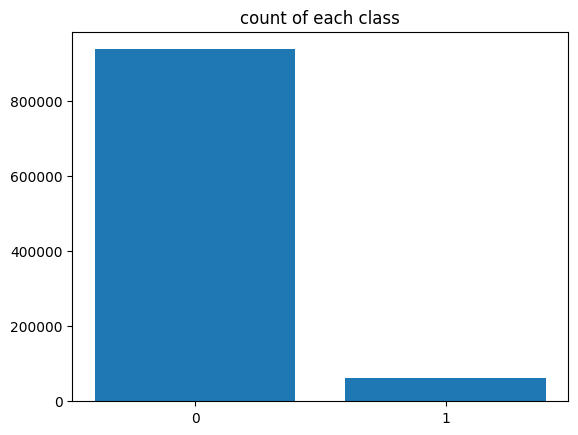

In [5]:
plt.bar(["0","1"],main_df["target"].value_counts(),width=0.8)
plt.title("count of each class")

In [6]:
def removeURL(column):
    return column.apply(lambda x: re.sub(r'http\S+', '', x))
def toLetter(column):
    return column.apply(lambda x : re.sub('[^a-zA-Z]',' ',x))

def expandContractions(column):
  contractions_expanded = column.apply(lambda x: [contractions.fix(word) for word in x.split()])
  return [' '.join(map(str, x)) for x in contractions_expanded]

def lowerCase(column):
  return column.apply(lambda x: [word.lower() for word in x])

def tokenize(data_column):
  print(np.shape(data_column))
  return data_column.apply(word_tokenize)

def remove_stopwords(data_column):
  stop_words = set.union(set(stopwords.words('english')),set(stopwords.words('arabic')),set(stopwords.words('french')),set(stopwords.words('german')),set(stopwords.words('italian')),set(stopwords.words('russian')),set(stopwords.words('spanish')))
  return data_column.apply(lambda x: [word for word in x if word not in stop_words])

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
def pos_tags(data_column):
  return data_column.apply(nltk.tag.pos_tag)

def to_wordnet(data_column):
  return data_column.apply(lambda words: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in words])
def word_lemmatizer(data_column):
  wnl = WordNetLemmatizer()
  return data_column.apply(lambda words: [wnl.lemmatize(word, tag) for word, tag in words])

In [7]:
def word_lemmatizer(data_column):
  wnl = WordNetLemmatizer()
  return data_column.apply(lambda words: [wnl.lemmatize(word, tag) for word, tag in words])

In [8]:
def pre_processing(data, df):
  data=removeURL(data)
  data=toLetter(data)
  df['sentences'] = expandContractions(data)
  data=tokenize(df['sentences'])
  df.drop('sentences', axis='columns', inplace=True)
  data = lowerCase(data)
  data = remove_stopwords(data)
  data = pos_tags(data)
  data = to_wordnet(data)
  return word_lemmatizer(data)

In [9]:
main_df_copy=main_df

In [10]:
main_df_copy_x=main_df_copy.drop(axis="columns",labels="target").to_numpy()
main_df_copy_y=main_df_copy["target"].to_numpy().astype(np.float64)

In [11]:
train_x,test_x,train_y,test_y=train_test_split(main_df_copy_x,main_df_copy_y,train_size=0.999,stratify=main_df_copy_y,shuffle=True)
train_df_x = pd.DataFrame(train_x, columns = ['qid', 'question_text'])


In [12]:
train_df_x["data"]=pre_processing(train_df_x["question_text"],train_df_x)

(999000,)


In [13]:
test_df["data"]=pre_processing(test_df["question_text"],test_df)

(306122,)


In [14]:
train_df_x.head()

,qid,question_text,data
0,033dc9456ddf582b98d2,Why is affirmative action available to Hispani...,"[affirmative, action, available, hispanic, asi..."
1,e1125db9c04989811e93,Why do I like femdom so much as a wife?,"[like, femdom, much, wife]"
2,b14d589c0528d0ac67b7,Which material fiitjee or Allen material is be...,"[material, fiitjee, material, best, iit]"
3,13ade151e001a8830732,Will Goku unlock both forms of Ultra Instinct?...,"[goku, unlock, form, ultra, instinct, could, a..."
4,68a252c635c2da7d583d,Is hiding all your sorrows and smiling is good...,"[hide, sorrow, smile, good, show, feeling, okay]"


## Lemmatizer

In [15]:
# lemmatizer = WordNetLemmatizer()
train_df_x['data'] = train_df_x['data'].apply(lambda words : ' '.join([w for w in words]))
train_df_x.head()

,qid,question_text,data
0,033dc9456ddf582b98d2,Why is affirmative action available to Hispani...,affirmative action available hispanic asian in...
1,e1125db9c04989811e93,Why do I like femdom so much as a wife?,like femdom much wife
2,b14d589c0528d0ac67b7,Which material fiitjee or Allen material is be...,material fiitjee material best iit
3,13ade151e001a8830732,Will Goku unlock both forms of Ultra Instinct?...,goku unlock form ultra instinct could anyone b...
4,68a252c635c2da7d583d,Is hiding all your sorrows and smiling is good...,hide sorrow smile good show feeling okay


In [16]:
# from nltk.stem import WordNetLemmatizer

In [17]:
test_df['data'] = test_df['data'].apply(lambda words : ' '.join([w for w in words]))
# test_df['data']

In [18]:
# test_df.head()

In [19]:
training_x,validation_x,training_y,validation_y=train_test_split(train_df_x["data"].to_numpy(),train_y,stratify=train_y,train_size=0.8)

## Count Vectorizer

In [20]:
vectorizer = CountVectorizer(ngram_range = (1,1))
vectorizer.fit(train_df_x['data'])
train_cv = vectorizer.transform(training_x)
validation_cv = vectorizer.transform(validation_x)

In [21]:
test_cv=vectorizer.transform(test_df["data"].to_numpy())

## Tf-Idf

In [22]:
vectorizer = TfidfVectorizer(ngram_range = (1,2))
vectorizer.fit(train_df_x['data'])
train_tf = vectorizer.transform(training_x)
validation_tf = vectorizer.transform(validation_x)

In [23]:
test_tf=vectorizer.transform(test_df["data"].to_numpy())

## Over sampling

In [24]:
sampler = RandomOverSampler(sampling_strategy=0.9)
train_cv,training_y_cv = sampler.fit_resample(train_cv,training_y)
train_tf,training_y_tf = sampler.fit_resample(train_tf,training_y)

## Logistic Regression

In [25]:
model = LogisticRegression(max_iter=1500, solver='lbfgs', penalty = 'l2')


#### Using Count Vectorization

In [26]:
model.fit(train_cv,training_y_cv)
pred_train=model.predict_proba(train_cv)[:,1]
pred_val=model.predict_proba(validation_cv)[:,1]
val=0.01
for i in range(1,91):
  y_pred_train=(pred_train>(val*i)).astype(np.int64)
  print(f1_score(training_y_cv,y_pred_train))

0.7001809136372149
0.733188079002418
0.7585382118081522
0.7793806567950896
0.7967299803827202
0.8117466956768061
0.8247912854073228
0.8365750041985183
0.8460096527710002
0.8541095999363717
0.8612172269131507
0.8673598148842347
0.87313061386645
0.8780046316547196
0.8824685703411853
0.8864733625429073
0.8899801134674644
0.8932253506472585
0.8963216520034817
0.899143810571136
0.9016103876325275
0.9039290669873604
0.9060145482546341
0.9078950082295529
0.9095337959960815
0.9110525747538196
0.9125564180132252
0.9139864891205676
0.9151990929249262
0.9163661213089985
0.9175032840993425
0.9184529596414764
0.9194776048301438
0.9200739442700269
0.9206993882268797
0.9212568963702117
0.9215953217208365
0.922135588665014
0.9223436981600419
0.9227431440788368
0.9228848701261303
0.9230104168320533
0.9226703561980073
0.9226203082886296
0.922364388014442
0.9221681110486658
0.9218165276392376
0.9214309262338918
0.9208733706566145
0.9204138796356021
0.9193772196133139
0.9187249066971493
0.918005603904177


In [27]:
for i in range(1,90):
    y_pred_val=(pred_val>val*i).astype(np.int64)
    print(f1_score(validation_y,y_pred_val))

0.14534756382707936
0.16590512529788376
0.1842767105023938
0.20123295534904617
0.21775929107514244
0.23335342263351283
0.2479676482787225
0.26192701404083607
0.27637042220667135
0.28848200198143326
0.2998556666794395
0.3109090667411041
0.32123767013831483
0.3315320453411278
0.34025981660004706
0.3495751480544659
0.3579796846762635
0.366749419396172
0.3743761491988442
0.3818319454958365
0.38920816270346537
0.39608587189487365
0.4025892520934569
0.4094969612652851
0.41553499477689904
0.42161093473756245
0.42843858969391707
0.43463684947445225
0.4401885089742304
0.4454402868025992
0.4501105440419861
0.4553026329591944
0.4604668995484365
0.46566634956326214
0.47012179094015594
0.47490227434257287
0.4791666666666667
0.4834739001595624
0.48727356640129227
0.49127893383212534
0.4956171523335702
0.49901702229681133
0.5025967092171043
0.5073570954825716
0.5106372402823341
0.514566037735849
0.5177303159127358
0.5213296969073226
0.5243299505594587
0.5277003209343926
0.5308760172331258
0.534078993

In [28]:
test_lr_cv_pred=model.predict_proba(test_cv)[:,1]
test_lr_cv_pred=(test_lr_cv_pred>0.75).astype(np.int64)

In [29]:
test_lr_cv_pred=pd.DataFrame(test_lr_cv_pred)
datasets=pd.concat([sub_df['qid'],test_lr_cv_pred],axis=1)
datasets.columns=["qid","target"]
datasets.to_csv("./test_lr_cv_pred.csv",index=False)


#### Using tf-idf

In [30]:
model.fit(train_tf,training_y_tf)
pred_train=model.predict_proba(train_tf)[:,1]
pred_val=model.predict_proba(validation_tf)[:,1]
val=0.1
for i in range(1,9):
  y_pred_train=(pred_train>(val*i)).astype(np.int64)
  print(f1_score(training_y_tf,y_pred_train))

0.8802607325436104
0.9306914708658289
0.9534015471087839
0.966427334740887
0.9747484405195468
0.9778735152638344
0.9678054012709928
0.9076734402260759


In [31]:
y_pred_val=(pred_val>0.3).astype(np.int64)
f1_score(validation_y,y_pred_val)

0.5086283027424399

In [33]:
test_lr_tf_pred=model.predict_proba(test_tf)[:,1]
test_lr_tf_pred=(test_lr_tf_pred>0.3).astype(np.int64)

In [34]:
test_lr_tf_pred=pd.DataFrame(test_lr_tf_pred)
datasets=pd.concat([sub_df['qid'],test_lr_tf_pred],axis=1)
datasets.columns=["qid","target"]
datasets.to_csv("./test_lr_tf_pred.csv",index=False)

## Perceptron

In [35]:
model = Perceptron()

#### Using Count Vectorization

In [36]:
model.fit(train_cv,training_y_cv)
pred_train=model.predict(train_cv)
pred_y=model.predict(validation_cv)
print(f1_score(training_y_cv,pred_train))
print(f1_score(validation_y,pred_y))

0.8717624359709233
0.4368842899327527


#### Using tf-idf

In [37]:
model.fit(train_tf,training_y_tf)
pred_train=model.predict(train_tf)
pred_y=model.predict(validation_tf)
print(f1_score(training_y_tf,pred_train))
print(f1_score(validation_y,pred_y))

0.9976981636461089
0.4952817224003665


## KNN

In [49]:
model =KNeighborsClassifier(n_neighbors=2)

using CV


In [50]:
model.fit(train_cv,training_y_cv)
pred_train=model.predict(train_cv)
pred_y=model.predict(validation_cv)
print(f1_score(training_y_cv,pred_train))
print(f1_score(validation_y,pred_y))

KeyboardInterrupt: 

using tf-idf

In [ ]:
model.fit(train_tf,training_y_tf)
pred_train=model.predict(train_tf)
pred_y=model.predict(validation_tf)
print(f1_score(training_y_tf,pred_train))
print(f1_score(validation_y,pred_y))

## Ridge classifier

In [38]:
model = RidgeClassifier()

#### Using Count Vectorization

In [39]:
model.fit(train_cv,training_y_cv)
pred_train=model.predict(train_cv)
pred_y=model.predict(validation_cv)
print(f1_score(training_y_cv,pred_train))
print(f1_score(validation_y,pred_y))

0.908953055473098
0.5136494446088056


#### Using tf-idf

In [40]:
model.fit(train_tf,training_y_tf)
pred_train=model.predict(train_tf)
pred_y=model.predict(validation_tf)
print(f1_score(training_y_tf,pred_train))
print(f1_score(validation_y,pred_y))

0.9946124831340403
0.5728050965558431


## Xg_boost

In [41]:
model = xgb.XGBClassifier()

#### Using Count Vectorization

In [42]:
model.fit(train_cv,training_y_cv)
pred_train=model.predict(train_cv)
pred_y=model.predict(validation_cv)
print(f1_score(training_y_cv,pred_train))
print(f1_score(validation_y,pred_y))

0.8254213948683873
0.47298182001309363


In [43]:
test_xg_cv_pred=model.predict(test_cv).astype(np.int64)
#test_xg_cv_pred=(test_xg_cv_pred>0.3).astype(np.int64)

In [44]:
test_xg_cv_pred=pd.DataFrame(test_xg_cv_pred)
datasets=pd.concat([sub_df['qid'],test_xg_cv_pred],axis=1)
datasets.columns=["qid","target"]
datasets.to_csv("./test_xg_cv_pred.csv",index=False)

#### Using tf-idf

In [46]:
model.fit(train_tf,training_y_tf)
pred_train=model.predict(train_tf)
pred_y=model.predict(validation_tf)
print(f1_score(training_y_tf,pred_train))
print(f1_score(validation_y,pred_y))

0.8305437155629484
0.4781827515400411


In [47]:
test_xg_tf_pred=model.predict(test_tf).astype(np.int64)

In [48]:
test_xg_tf_pred=pd.DataFrame(test_xg_tf_pred)
datasets=pd.concat([sub_df['qid'],test_xg_tf_pred],axis=1)
datasets.columns=["qid","target"]
datasets.to_csv("./test_xg_tf_pred.csv",index=False)